In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
from dateutil.relativedelta import relativedelta

def calculate_one_year_earlier(most_recent_date_string):
        
    # Convert the string date to a datetime object
    most_recent_date = dt.datetime.strptime(most_recent_date_string, '%Y-%m-%d')

    # Calculate the date one year earlier
    one_year_earlier_date = most_recent_date - relativedelta(years=1)

    # Convert the date back to a string
    one_year_earlier_date_string = one_year_earlier_date.strftime('%Y-%m-%d')

    return one_year_earlier_date_string

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(
    measurement.date
).order_by(
    measurement.date.desc()
).first()

print(most_recent_date_row)
print("")
print(f"The most recent date in the data set: {most_recent_date_row.date}")

('2017-08-23',)

The most recent date in the data set: 2017-08-23


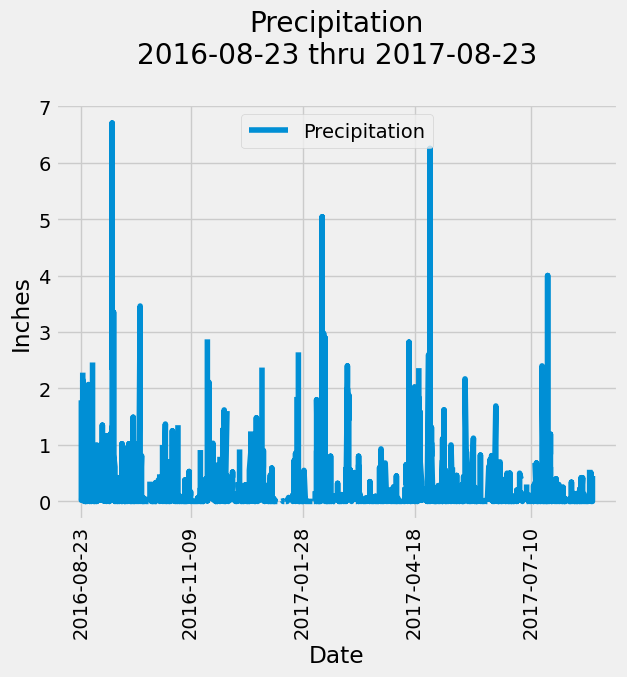

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_earlier_date_string = calculate_one_year_earlier(most_recent_date_row.date)

# Perform a query to retrieve the data and precipitation scores
measurements = session.query(
    measurement.prcp, measurement.date
).filter(
    measurement.date >= one_year_earlier_date_string
).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(measurements, columns=['Precipitation','Date'])

# Sort the dataframe by date
df_sorted = df.sort_values(by='Date', ascending=True)

# Convert Date from string to datetime (for a correct plot)
df_sorted["Date"]=pd.to_datetime(df_sorted["Date"])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6.5,7))
plt.plot(df_sorted['Date'], df_sorted['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title(f'Precipitation\n{one_year_earlier_date_string} thru {most_recent_date_row.date}\n')
custom_dates = ["2016-08-23", "2016-11-09", "2017-01-28", "2017-04-18", "2017-07-10"]
plt.xticks(custom_dates, rotation=90)
plt.legend(loc='upper center')
plt.tight_layout()

plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(
    df_sorted['Precipitation'].describe()
)

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(
    func.count(
        func.distinct(station.station)
    )
).all()

print(stations)
print("")
print(f"Total number of stations in the dataset: {stations[0][0]}")

[(9,)]

Total number of stations in the dataset: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(
    measurement.station, func.count(measurement.station)
).group_by(
    measurement.station
).order_by(
    func.count(measurement.station).desc()
).all()

print("Station and Activity Counts (by Descending Activity Order):")
station_activity

Station and Activity Counts (by Descending Activity Order):


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = station_activity[0][0]

summary_station_activity = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(
    measurement.station == most_active_station_id
).all()

print( summary_station_activity )
print("")
print(f"Most Active Station: {most_active_station_id}")
print(f"  Lowest  Temperature: {summary_station_activity[0][0]:.2f}")
print(f"  Highest Temperature: {summary_station_activity[0][1]:.2f}")
print(f"  Average Temperature: {summary_station_activity[0][2]:.2f}")

[(54.0, 85.0, 71.66378066378067)]

Most Active Station: USC00519281
  Lowest  Temperature: 54.00
  Highest Temperature: 85.00
  Average Temperature: 71.66


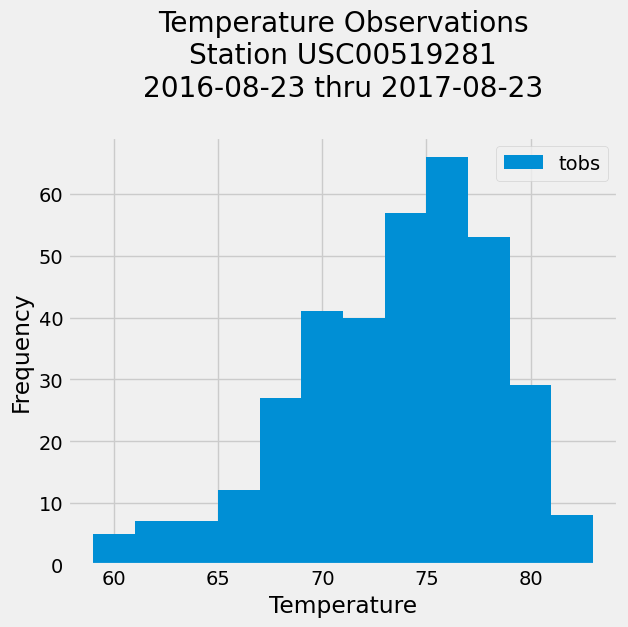

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
full_station_activity = session.query(
    measurement.tobs
).filter(
    measurement.station == most_active_station_id
).filter(
    measurement.date >= one_year_earlier_date_string
).all()

full_station_activity_df = pd.DataFrame(full_station_activity)

plt.figure(figsize=(6.5,6.5))
plt.hist(full_station_activity_df['tobs'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations\nStation {most_active_station_id}\n{one_year_earlier_date_string} thru {most_recent_date_row.date}\n')
plt.legend()
plt.tight_layout()

plt.show()

# Close Session

In [17]:
# Close Session
session.close()